In [1]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.gridspec import GridSpec

In [2]:
pd.set_option('display.max_columns', 999)
%matplotlib inline
mpl.rcParams['figure.facecolor'] = 'white'

In [3]:
HOME_TEAM = "England"
AWAY_TEAM = "Germany"
PITCH_MAX_X = 105
PITCH_MAX_Y = 68

In [4]:
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r')
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

In [5]:
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

In [6]:
match_html_path = './reasources/htmls/England 2-0 Germany - European Championship 2020 Live.html'
json_data_txt = extract_json_from_html(match_html_path)

In [7]:
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

In [8]:
teams_dict

{345: 'England', 336: 'Germany'}

In [9]:
players_df.head()

,playerId,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId
0,110189,1,Jordan Pickford,GK,185,77,27,True,False,home,"{'totalSaves': {'3': 1.0, '31': 1.0, '49': 1.0...",NaN,NaN,NaN,NaN,NaN,NaN,345
1,69778,2,Kyle Walker,DC,178,70,31,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '2': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,345
2,99487,6,Harry Maguire,DC,194,100,28,True,True,home,"{'possession': {'0': 2.0, '4': 2.0, '5': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,345
3,101374,5,John Stones,DC,188,70,27,True,False,home,"{'possession': {'0': 1.0, '4': 2.0, '5': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,345
4,83078,12,Kieran Trippier,DMR,178,71,30,True,False,home,"{'possession': {'4': 2.0, '6': 1.0, '11': 1.0,...",NaN,NaN,NaN,NaN,NaN,NaN,345


In [10]:
df = pd.DataFrame(events_dict)
df.head()

,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,cardType,relatedEventId,relatedPlayerId,isGoal
0,2.308643e+09,2,0,0.0,345,0.0,0.0,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 32, 'displayName': 'Start'}","{'value': 1, 'displayName': 'Successful'}",[],[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.308643e+09,2,0,0.0,336,0.0,0.0,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 32, 'displayName': 'Start'}","{'value': 1, 'displayName': 'Successful'}",[],[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.308643e+09,3,0,1.0,336,49.8,50.0,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}","{'value': 1, 'displayName': 'Successful'}","[{'type': {'value': 140, 'displayName': 'PassE...","[90, 116, 29, 34, 36, 215, 217]",True,130903.0,36.0,56.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.308643e+09,4,0,2.0,336,35.7,56.6,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}","{'value': 1, 'displayName': 'Successful'}","[{'type': {'value': 56, 'displayName': 'Zone'}...","[90, 116, 29, 34, 37, 215, 217]",True,31772.0,34.5,46.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.308643e+09,5,0,3.0,336,33.8,46.3,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}","{'value': 1, 'displayName': 'Successful'}","[{'type': {'value': 140, 'displayName': 'PassE...","[90, 116, 29, 34, 36, 214, 217]",True,115519.0,26.9,52.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'blockedX', 'blockedY', 'goalMouthZ', 'goalMouthY', 'isShot',
       'cardType', 'relatedEventId', 'relatedPlayerId', 'isGoal'],
      dtype='object')

In [12]:
df = pd.DataFrame(events_dict)

df["eventType"] = df.apply(lambda row: row["type"]["displayName"], axis=1)
df["outcomeType"] = df.apply(lambda row: row["outcomeType"]["displayName"], axis=1)
df["half"] = df.apply(lambda row: row["period"]["displayName"], axis=1)

df["x"] = df["x"].apply(lambda row: row / 100 * PITCH_MAX_X)
df["endX"] = df["endX"].apply(lambda row: row / 100 * PITCH_MAX_X)
df["y"] = df["y"].apply(lambda row: row / 100 * PITCH_MAX_Y)
df["endY"] = df["endY"].apply(lambda row: row / 100 * PITCH_MAX_Y)

df["time"] = df["minute"] + df["second"] / 100

df.replace(teams_dict, inplace=True)

recivers= []
for idx, row in df.iterrows():
    if row["eventType"] == "Pass" and row["outcomeType"] == "Successful":
        player_team = players_df[players_df.playerId == row["playerId"]]["teamId"].item()
        try:
            reciver_team = players_df[players_df.playerId == df.iloc[idx+1, 14]]["teamId"].item()
        except ValueError:
            reciver_team = 0
        # print(player_team, reciver_team)
        if player_team == reciver_team:
            recivers.append(df.iloc[idx+1, 14])
        else:
            recivers.append(np.nan)
    else:
        recivers.append(np.nan)
df["reciverId"] = recivers

df.drop(columns=["id", "period", "type", "minute", "second"], inplace=True)
# TODO change columns order
df.head()

,eventId,teamId,x,y,expandedMinute,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,cardType,relatedEventId,relatedPlayerId,isGoal,eventType,half,time,reciverId
0,2,England,0.000,0.000,0,Successful,[],[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Start,FirstHalf,0.00,NaN
1,2,Germany,0.000,0.000,0,Successful,[],[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Start,FirstHalf,0.00,NaN
2,3,Germany,52.290,34.000,0,Successful,"[{'type': {'value': 140, 'displayName': 'PassE...","[90, 116, 29, 34, 36, 215, 217]",True,130903.0,37.800,38.352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,FirstHalf,0.01,31772.0
3,4,Germany,37.485,38.488,0,Successful,"[{'type': {'value': 56, 'displayName': 'Zone'}...","[90, 116, 29, 34, 37, 215, 217]",True,31772.0,36.225,31.688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,FirstHalf,0.02,115519.0
4,5,Germany,35.490,31.484,0,Successful,"[{'type': {'value': 140, 'displayName': 'PassE...","[90, 116, 29, 34, 36, 214, 217]",True,115519.0,28.245,35.904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,FirstHalf,0.03,21541.0


In [13]:
FIRST_HOME_SUB = df[(df.eventType == 'SubstitutionOn') & (df.teamId == HOME_TEAM)]["time"].head(1).item()
FIRST_AWAY_SUB = df[(df.eventType == 'SubstitutionOn') & (df.teamId == AWAY_TEAM)]["time"].head(1).item()

In [14]:
def get_value_from_qualifiers(row, key):
    for d in row:
        if d["type"]["displayName"] == key:
            return d["value"]
    return np.nan

In [15]:
passes = df.loc[df.index[df.eventType == "Pass"], ["teamId", "playerId", "x", "y", "endX", "endY", "outcomeType", "half", "time", "qualifiers"]]
passes["length"] = passes.apply(lambda row: get_value_from_qualifiers(row["qualifiers"], "Length"), axis=1)
passes["zone"] = passes.apply(lambda row: get_value_from_qualifiers(row["qualifiers"], "Zone"), axis=1)
passes.drop(columns=["qualifiers"], inplace=True)
passes

,teamId,playerId,x,y,endX,endY,outcomeType,half,time,length,zone
2,Germany,130903.0,52.290,34.000,37.800,38.352,Successful,FirstHalf,0.01,15.1,Back
3,Germany,31772.0,37.485,38.488,36.225,31.688,Successful,FirstHalf,0.02,6.9,Back
4,Germany,115519.0,35.490,31.484,28.245,35.904,Successful,FirstHalf,0.03,8.5,Back
5,Germany,21541.0,28.245,35.904,35.805,4.624,Successful,FirstHalf,0.05,32.2,Back
6,Germany,283323.0,34.020,10.200,88.620,34.680,Unsuccessful,FirstHalf,0.09,59.8,Center
...,...,...,...,...,...,...,...,...,...,...,...
1503,Germany,144711.0,71.820,50.660,75.180,43.248,Unsuccessful,SecondHalf,93.55,8.1,Center
1504,England,270446.0,28.875,29.308,38.220,35.428,Unsuccessful,SecondHalf,93.55,11.2,Back
1505,Germany,111212.0,64.260,33.796,67.410,15.640,Successful,SecondHalf,93.58,18.4,Center
1506,Germany,31772.0,67.200,16.728,94.500,37.944,Unsuccessful,SecondHalf,94.01,34.6,Center


In [16]:
england_passes = passes[(passes.teamId == HOME_TEAM)]
england_passes

,teamId,playerId,x,y,endX,endY,outcomeType,half,time,length,zone
8,England,110189.0,15.435,31.484,28.770,17.612,Successful,FirstHalf,0.15,19.2,Back
9,England,69778.0,28.980,17.544,29.295,25.160,Successful,FirstHalf,0.17,7.6,Back
10,England,101374.0,28.140,25.636,31.920,52.904,Successful,FirstHalf,0.19,27.5,Back
11,England,99487.0,35.805,55.420,55.440,59.908,Successful,FirstHalf,0.23,20.1,Left
12,England,97692.0,49.140,60.316,37.905,59.024,Successful,FirstHalf,0.26,11.3,Back
...,...,...,...,...,...,...,...,...,...,...,...
1458,England,110189.0,4.830,38.012,64.995,52.292,Unsuccessful,SecondHalf,91.43,61.8,Center
1464,England,270446.0,55.650,47.532,82.845,51.952,Unsuccessful,SecondHalf,91.50,27.6,Center
1477,England,118244.0,24.780,44.676,36.645,41.004,Successful,SecondHalf,92.16,12.4,Back
1484,England,110189.0,15.435,55.216,90.930,46.308,Unsuccessful,SecondHalf,92.47,76.0,Center


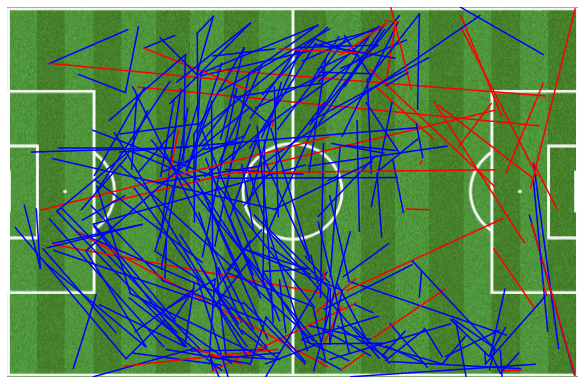

In [17]:
plt.figure(figsize=(PITCH_MAX_X/10, PITCH_MAX_Y / 10))
plt.xlim((0, PITCH_MAX_X))
plt.ylim((0, PITCH_MAX_Y))
plt.axis("off")
im = plt.imread("./reasources/images/football_pitch_resized.png")
plt.imshow(im, extent=[0, PITCH_MAX_X, 0, PITCH_MAX_Y])

for idx, row in england_passes.iterrows():
    if row["half"] == "FirstHalf":
        x_values = (row["x"], row["endX"])
        y_values = (row["y"], row["endY"])
        color = "blue" if row["outcomeType"] == "Successful" else "red"
        plt.plot(x_values, y_values, color=color)
plt.show()

In [18]:
# shots = df.loc[df.index[df.eventType == "Shot"], ["teamId", "playerId", "x", "y", "endX", "endY", "outcomeType", "half", "time", "qualifiers"]]
# # passes["length"] = passes.apply(lambda row: get_value_from_qualifiers(row["qualifiers"], "Length"), axis=1)
# # passes["zone"] = passes.apply(lambda row: get_value_from_qualifiers(row["qualifiers"], "Zone"), axis=1)
# # passes.drop(columns=["qualifiers"], inplace=True)
# shots

England's goalkeeper passes

In [19]:
england_goalkeeper_passes = england_passes[england_passes["playerId"] == 110189]
england_goalkeeper_passes.head()

,teamId,playerId,x,y,endX,endY,outcomeType,half,time,length,zone
8,England,110189.0,15.435,31.484,28.770,17.612,Successful,FirstHalf,0.15,19.2,Back
26,England,110189.0,24.045,53.312,97.860,46.172,Unsuccessful,FirstHalf,1.49,74.2,Center
67,England,110189.0,10.080,30.940,35.910,4.624,Successful,FirstHalf,4.06,36.9,Back
86,England,110189.0,8.715,24.276,58.485,15.300,Unsuccessful,FirstHalf,5.01,50.6,Center
103,England,110189.0,16.485,34.204,29.925,54.332,Successful,FirstHalf,5.47,24.2,Back


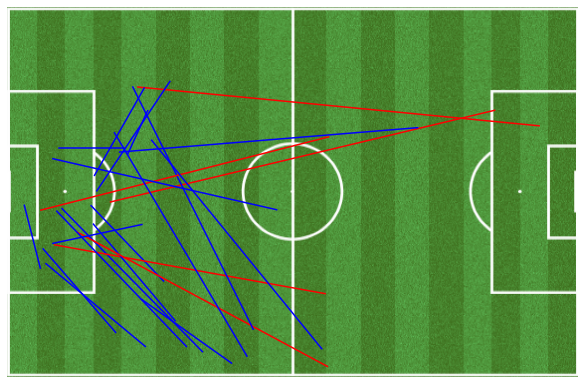

In [20]:
plt.figure(figsize=(PITCH_MAX_X / 10, PITCH_MAX_Y / 10))
plt.xlim((0, PITCH_MAX_X))
plt.ylim((0, PITCH_MAX_Y))
plt.axis("off")
im = plt.imread("./reasources/images/football_pitch_resized.png")
plt.imshow(im, extent=[0, PITCH_MAX_X, 0, PITCH_MAX_Y])

for idx, row in england_goalkeeper_passes.iterrows():
    if row["half"] == "FirstHalf":
        x_values = (row["x"], row["endX"])
        y_values = (row["y"], row["endY"])
        color = "blue" if row["outcomeType"] == "Successful" else "red"
        plt.plot(x_values, y_values, color=color)
plt.show()

In [21]:
avg_position = england_passes.loc[df.time < FIRST_HOME_SUB].groupby(["playerId"])[["x", "y"]].mean()

In [22]:
by_player = df[(df.teamId == HOME_TEAM) & (df.eventType == "Pass") & (df.outcomeType == "Successful") & (df.time < FIRST_HOME_SUB)]\
            .groupby(['playerId', 'reciverId'])\
            .size()\
            .reset_index(name="Count")\
            .pivot(index="playerId", columns="reciverId", values="Count")\
            .merge(avg_position, how="right", on="playerId")
by_player


,69778.0,83078.0,83532.0,97692.0,99487.0,101374.0,110189.0,118244.0,270446.0,332325.0,367185.0,x,y
playerId,,,,,,,,,,,,,
69778.0,NaN,6.0,1.0,NaN,2.0,8.0,6.0,NaN,12.0,2.0,6.0,46.166321,15.504000
83078.0,7.0,NaN,1.0,2.0,3.0,3.0,3.0,1.0,5.0,2.0,11.0,63.140700,10.703200
83532.0,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,1.0,2.0,3.0,63.778750,42.953333
97692.0,NaN,NaN,3.0,NaN,3.0,NaN,NaN,2.0,2.0,4.0,1.0,63.015750,53.393600
99487.0,6.0,NaN,2.0,4.0,NaN,11.0,1.0,10.0,2.0,2.0,1.0,44.270930,49.923070
101374.0,8.0,3.0,NaN,1.0,11.0,NaN,6.0,4.0,10.0,6.0,1.0,36.404118,29.374667
110189.0,5.0,2.0,2.0,NaN,3.0,5.0,NaN,1.0,2.0,NaN,NaN,13.992222,34.745481
118244.0,NaN,NaN,NaN,5.0,10.0,2.0,NaN,NaN,1.0,6.0,3.0,54.417794,60.720000
270446.0,7.0,9.0,NaN,2.0,4.0,6.0,2.0,NaN,NaN,8.0,NaN,53.950909,24.571182


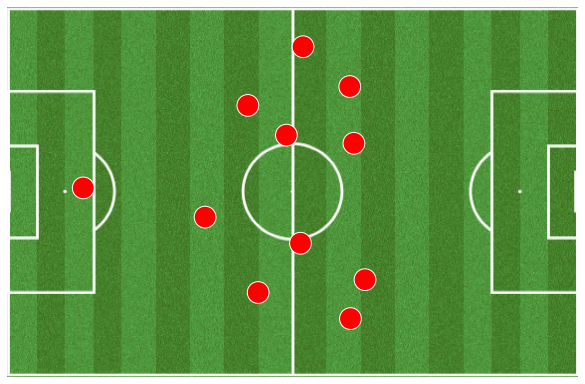

In [23]:
plt.figure(figsize=(PITCH_MAX_X / 10, PITCH_MAX_Y / 10))
plt.xlim((0, PITCH_MAX_X))
plt.ylim((0, PITCH_MAX_Y))
plt.axis("off")
im = plt.imread("./reasources/images/football_pitch_resized.png")
plt.imshow(im, extent=[0, PITCH_MAX_X, 0, PITCH_MAX_Y])

for idx, row in by_player.iterrows():
    player_circle = plt.Circle((row["x"], row["y"]), radius=2, color="r", ec="white")
    plt.gca().add_patch(player_circle)

plt.show()

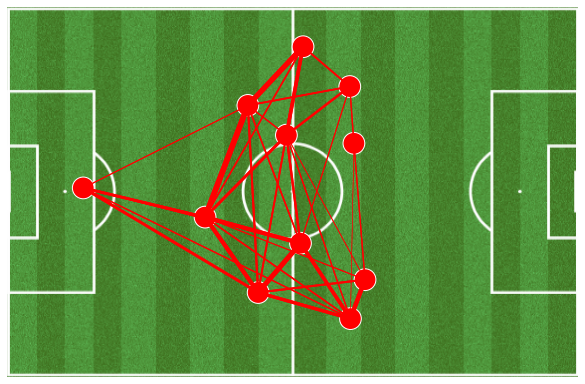

In [24]:
plt.figure(figsize=(PITCH_MAX_X / 10, PITCH_MAX_Y / 10))
plt.xlim((0, PITCH_MAX_X))
plt.ylim((0, PITCH_MAX_Y))
plt.axis("off")
im = plt.imread("./reasources/images/football_pitch_resized.png")
plt.imshow(im, extent=[0, PITCH_MAX_X, 0, PITCH_MAX_Y])

players_id = by_player.columns[:-2]

for idx, row in by_player.iterrows():
    player_id = row.name
    for reciver_id in players_id:
        count = by_player.loc[player_id, reciver_id] + by_player.loc[reciver_id, player_id]
        x_values = (by_player.loc[player_id, "x"], by_player.loc[reciver_id, "x"])
        y_values = (by_player.loc[player_id, "y"], by_player.loc[reciver_id, "y"])
        plt.plot(x_values, y_values, color="r", linewidth=count/4)

for idx, row in by_player.iterrows():
    player_circle = plt.Circle((row["x"], row["y"]), radius=2, color="r", ec="white")
    plt.gca().add_patch(player_circle)


plt.show()

In [95]:
def plot_player_passes(ax: mpl.axes.Axes, df: pd.DataFrame, player_id: int):
    ax.set_xlim((0, PITCH_MAX_X))
    ax.set_ylim((0, PITCH_MAX_Y))
    ax.axis("off")
    im = plt.imread("./reasources/images/football_pitch_resized.png")
    ax.imshow(im, extent=[0, PITCH_MAX_X, 0, PITCH_MAX_Y])
    title = players_df[players_df.playerId == player_id]["name"].item()
    ax.set_title(title)

    df = df[df["playerId"] == player_id]

    for idx, row in df.iterrows():
        x_values = (row["x"], row["endX"])
        y_values = (row["y"], row["endY"])
        color = "blue" if row["outcomeType"] == "Successful" else "red"
        ax.plot(x_values, y_values, color=color)
    return ax

In [96]:
players_ids = england_passes.groupby(["playerId"]).size().sort_values(ascending=False).reset_index().playerId.to_list()
players_ids

[69778.0,
 83078.0,
 101374.0,
 270446.0,
 99487.0,
 332325.0,
 118244.0,
 110189.0,
 97692.0,
 367185.0,
 83532.0,
 113069.0]

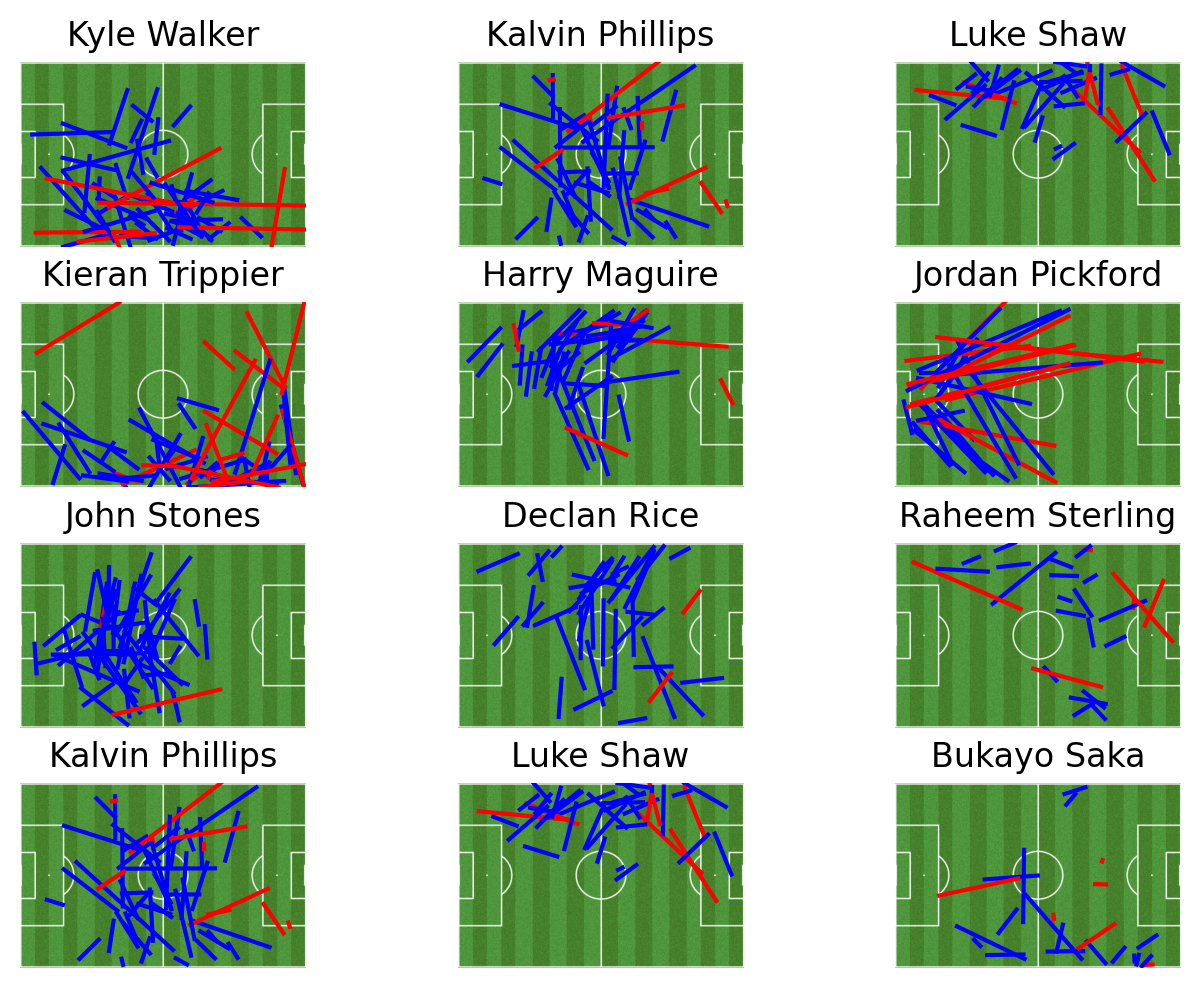

In [102]:
fig = plt.figure(figsize=(8, 6), dpi=200)
nrows = 4
ncols = 3

gspec = GridSpec(ncols=ncols, nrows=nrows, figure=fig, hspace=0.3)
plot_counter = 0
for row in range(nrows):
    for col in range(ncols):
        ax = plt.subplot(
                gspec[row, col],
                facecolor = "#EFE9E6"
            )
        player_id = players_ids[row + col * ncols]
        plot_player_passes(ax, england_passes, player_id)